# S3 TS practical session: (1h30)

# Using Pytorch : TimeSeries and Neural Nets `torch.nn` :


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import logging

logging.basicConfig(level=logging.INFO)


We'll keep it simple and only consider 1-dimensional convolutions

# `torch.nn` interesting parts for series

Before doing any specific task, lets just review some of the interesting bits available for timeseries in pytorch.

# (A) Dealing with variable length input with 1dConv & RNN's

Let's create two dummy series of two different length

In [2]:
x_long = torch.rand(1,1,33)  ## Data needs to be 3d for 1d convolutions ! (batch,serie_size,seq)
x_small = torch.rand(1,1,10)

print(x_long)
print(x_small)

tensor([[[0.7308, 0.6269, 0.5641, 0.7908, 0.4936, 0.2229, 0.8124, 0.2558,
          0.0164, 0.8950, 0.6964, 0.9653, 0.6138, 0.1344, 0.1115, 0.3200,
          0.9870, 0.8439, 0.0221, 0.1231, 0.1145, 0.7269, 0.1690, 0.8651,
          0.2605, 0.2265, 0.6158, 0.3138, 0.0770, 0.6195, 0.2855, 0.6974,
          0.6119]]])
tensor([[[0.4041, 0.2329, 0.6244, 0.5621, 0.3285, 0.3897, 0.7083, 0.6154,
          0.1115, 0.8091]]])





## 1-Dimensional Convolutions:

1D Convolutions are like a sliding window over the serie:

`channel` is the number observations that belongs together, multivariable series have multiple channels (for example, RGB images have 3 channels)

Convolutions have multiple parameters:

[`torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_modea='zeros')`](https://pytorch.org/docs/stable/nn.html#conv1d)


- `stride` controls the stride for the cross-correlation, a single number or a one-element tuple.

- `padding` controls the amount of implicit zero-paddings on both sides for padding number of points.

- `dilation` controls the spacing between the kernel points; also known as the à trous algorithm. It is harder to describe, but this link has a nice visualization of what dilation does.

- `groups` controls the connections between inputs and outputs. in_channels and out_channels must both be divisible by groups


## [>> Have a look at this visualization to understand how they behave ! <<](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)


## Knowing the output size:

This formula should give you the output size per channel

$$ \frac{(W−K+2P)}{S}+1$$

- W is the input volume
- K is the Kernel size
- P is the padding
- S is the stride

## basic 1-d => one sliding window

With one input channel and one output channel

In [3]:
conv_module1 = torch.nn.Conv1d(1,1,4,stride=1)
output_long = conv_module1(x_long)
output_small = conv_module1(x_small)

print(output_long.size()) #24-4+1 (we roll with 4-sized windows and calculate a filter) => 21 values
print(output_long)


print(output_small.size()) #24-4+1 (we roll with 4-sized windows and calculate a filter) => 21 values
print(output_small)


torch.Size([1, 1, 30])
tensor([[[ 0.1135, -0.0249,  0.1645,  0.2494, -0.1541,  0.1939,  0.2831,
          -0.3274, -0.0752, -0.0008,  0.1953,  0.3943,  0.1733, -0.0819,
          -0.3324, -0.0024,  0.5129,  0.2076, -0.0059, -0.2416,  0.1514,
          -0.1296,  0.1839,  0.2123, -0.1285,  0.1134,  0.2273, -0.1548,
           0.0649, -0.0631]]], grad_fn=<SqueezeBackward1>)
torch.Size([1, 1, 7])
tensor([[[-0.1005, -0.0051,  0.1892,  0.0704, -0.1192,  0.0432,  0.3109]]],
       grad_fn=<SqueezeBackward1>)


### => The sizes are not the same :(



## basic 1-d => multiple sliding windows + max-pooling along channels

With one input channel and MORE output channel

In [4]:
conv_module1 = torch.nn.Conv1d(1,4,4)

output_long,_ =  torch.max(conv_module1(x_long), dim=-1)
output_small,_ = torch.max(conv_module1(x_small), dim=-1)



print(output_long.size()) 
print(output_long)

print("")

print(output_small.size()) 
print(output_small)



torch.Size([1, 4])
tensor([[0.0736, 0.0080, 0.6271, 0.4685]], grad_fn=<MaxBackward0>)

torch.Size([1, 4])
tensor([[-0.2602, -0.1710,  0.5110,  0.3589]], grad_fn=<MaxBackward0>)


### => Now, they have the same size ! :)

## RNNs


RNN's are neural networks cells that processes the time serie sequentially (time-step after time-step) instead of in parallel like CNN's. This is because each output at time $t$ is conditioned on $t-1$

In [5]:
x_long_rnn = torch.rand(1,33,6)  ## Data needs to be 3d for RNN ! (batch,seq,serie_size)
x_small_rnn = torch.rand(1,12,6) 

### [`torch.nn` rnn'](https://pytorch.org/docs/stable/nn.html#recurrent-layers)


You have two kinds:
    - (RNN/GRU/LSTM) => These cells processes the whole sequence in one operation X(SEQ) => OUT 
    - (RNN/GRU/LSTM)Cell => These cells require a for loop to process a whole sequence X(s)=>X(e)=>X(q) => OUT
    
 Both can take variable length inputs. For the former you'll have to pad with 0's so each sequences are of same length. The Latter (XCell) processes inputs via a `for` loop, so padding can be avoided.
 

In [6]:
small_rnn = nn.RNN(5,5)
small_gru = nn.GRU(5,5)
small_lstm = nn.LSTM(5,5)

## Pytorch's RNN  all behave in the same way:

### (TODO) => Try different the "CELL" variables

In [21]:
CELL = small_lstm#To complete #small_rnn # small_gru # small_lstm


output,hidden = CELL(torch.rand(1,4,5)) # Processes a batch of 1 series of 4 timesteps of 5 values

print("output:")
print("------")
print(output)
print(output.size())


full_seq_rnn = output[:,-1,:] # We select the output of the last timestep.
full_seq_max,_ = torch.max(output,1) # we aggregate on the sequence dimension

print("\n\n")

print("\"aggregation\"")
print("---")
print(full_seq_rnn)
print(full_seq_max)

output:
------
tensor([[[ 0.1941,  0.1952, -0.1692,  0.0500,  0.0701],
         [ 0.1619,  0.2273, -0.0063,  0.0054,  0.0337],
         [ 0.1575,  0.1988, -0.0164,  0.0113,  0.1283],
         [ 0.2124,  0.2129, -0.1088,  0.0130,  0.1008]]],
       grad_fn=<StackBackward>)
torch.Size([1, 4, 5])



"aggregation"
---
tensor([[ 0.2124,  0.2129, -0.1088,  0.0130,  0.1008]],
       grad_fn=<SliceBackward>)
tensor([[ 0.2124,  0.2273, -0.0063,  0.0500,  0.1283]], grad_fn=<MaxBackward0>)


The output size has the same length at the sequence because there is one output per timestep (dimension #1);
To have


## (TODO) process `x_long_rnn` and `x_small_rnn` with a `rnn_cell` so they have the same size


In [29]:
rnn_cell = nn.RNN(6, 10)## To complete

out_long,_ = rnn_cell(x_long_rnn)
out_small,_ = rnn_cell(x_small_rnn)

out_long = out_long[:,-1,:] # to complete
out_small = out_small[:,-1,:] # to complete

print(out_small.size())
print(out_long.size())


print("Outputs are of equal sizes:", out_long.size() == out_small.size())


torch.Size([1, 10])
torch.Size([1, 10])
Outputs are of equal sizes: True


### => Take a moment to ponder on what output size is

## Pytorch's Cells also all *nearly behave in the same way:

*The LSTMCell output is a tuple of tensors instead of just one tensor (it returns cell state)


In [30]:
small_rnnC = nn.RNNCell(5,5)
small_gruC = nn.GRUCell(5,5)
small_lstmC = nn.LSTMCell(5,5)

small_rnnC(torch.rand(1,5)) # Processes one example of size 5

tensor([[ 0.0337, -0.3135,  0.3543, -0.1711,  0.4147]], grad_fn=<TanhBackward>)

In [31]:
CELL = small_lstmC#To complete #small_rnnC # small_gruC # small_lstmC


input_seq = torch.rand(1,4,5)

outputs = []
for i in range(input_seq.size(1)): #for every indices of the sequence
    
    input_vec = input_seq[:,i,:]     # we take the vector of one timestep
    output = CELL(input_vec) # Processes a batch of 1 series of 4 timesteps of 5 values
    
    if type(output) is tuple: # if it's a lstm
        output,_ = output
        
    outputs.append(output)
        
        
print("outputs:")
print("------")
print(outputs)
print("")
print("outputs.size()")
print("------")
print([x.size() for x in outputs])


print("\n"*2)

print("aggregation")
print("------")

concatenated = torch.cat(outputs,dim=0)
maxed,_ = torch.max(concatenated,dim=0)


print(outputs[-1])  #we can just select the last one
print(maxed)
print() #or do a max



outputs:
------
[tensor([[ 0.1333, -0.0484, -0.0762,  0.0455,  0.0462]], grad_fn=<MulBackward0>), tensor([[ 0.1210, -0.0565, -0.0264,  0.0368,  0.1060]], grad_fn=<MulBackward0>), tensor([[ 0.1542, -0.0217, -0.1352,  0.0074,  0.0390]], grad_fn=<MulBackward0>), tensor([[ 0.1939, -0.0454, -0.1444,  0.0185,  0.1155]], grad_fn=<MulBackward0>)]

outputs.size()
------
[torch.Size([1, 5]), torch.Size([1, 5]), torch.Size([1, 5]), torch.Size([1, 5])]



aggregation
------
tensor([[ 0.1939, -0.0454, -0.1444,  0.0185,  0.1155]], grad_fn=<MulBackward0>)
tensor([ 0.1939, -0.0217, -0.0264,  0.0455,  0.1155], grad_fn=<MaxBackward0>)



## (TODO) process `x_long_rnn` and `x_small_rnn` with a `*(RNN)Cell` so they have the same size

In [44]:
CELL_C = nn.RNNCell(6,10) ## To complete

# To complete
outputs = []
for i in range(x_long_rnn.size(1)): #for every indices of the sequence
    
    input_vec = x_long_rnn[:,i,:]     # we take the vector of one timestep
    output = CELL_C(input_vec) # Processes a batch of 1 series of 4 timesteps of 5 values
    
    if type(output) is tuple: # if it's a lstm
        output,_ = output
        
    outputs.append(output)
out_long = outputs[-1]
    
outputs = []
for i in range(x_small_rnn.size(1)): #for every indices of the sequence
    
    input_vec = x_small_rnn[:,i,:]     # we take the vector of one timestep
    output = CELL_C(input_vec) # Processes a batch of 1 series of 4 timesteps of 5 values
    
    if type(output) is tuple: # if it's a lstm
        output,_ = output
        
    outputs.append(output)
out_small = outputs[-1]

print(out_small.size())
print(out_long.size())


print("Outputs are of equal sizes:", out_long.size() == out_small.size())

torch.Size([1, 10])
torch.Size([1, 10])
Outputs are of equal sizes: True


# (B) Using those parts for classification
## Here, we are in the supervised learning framework: Signal classification

###  We propose to reuse our simple timeseries classification task to tryout those convolutions/rnn's



Given this dataset, we'll do the same task as before: prediction of the day of the week.

### (a) Loading data/create dataset

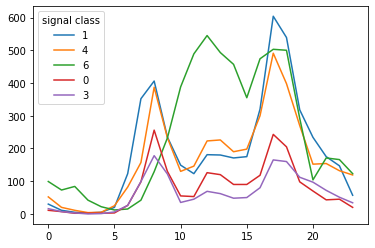

In [79]:
#lets load the data and only consider the count as a serie.
df = pd.read_csv("https://raw.githubusercontent.com/cedias/csvdata/master/train.csv",parse_dates=["datetime"],usecols=['datetime','count'])
df.head()

df["y"] = df.datetime.dt.weekday
df["day"] = df.datetime.dt.day
df["hour"] = df.datetime.dt.hour
df["month"] = df.datetime.dt.month
df["time"] = df.datetime.dt.time
df["year"] = df.datetime.dt.year

hour_index = list(range(24))

def paddedlist(df):
    ndf = df.set_index("hour")
    
    if len(df.index.values) < 24:
        ndf = ndf.reindex(hour_index).fillna(0)
     
    # Here: I fill missing data with a 0, I could have used other strategies:
    #pad / ffill: propagate last valid observation forward to next valid
    #backfill / bfill: use next valid observation to fill gap
    #nearest: use nearest valid observations to fill gap
        
    counts = ndf["count"].tolist()
    weekday = ndf.iloc[0]["y"]
    
    return  (counts,weekday)


X,Y = zip(*(df.groupby(["day","month","year"])["hour","count","y"]
            .apply(paddedlist)
            .reset_index(drop=True)
            .sample(frac=1)
            .tolist()
           ))

X = np.array(X)
Y = np.array(Y)


for x,y in zip(X[:5],Y[:5]):
    plt.plot(x,label=int(y))
    plt.legend(title="signal class")
    
X_train = X[:-42]
Y_train = Y[:-42]

X_test = X[-42:]
Y_test = Y[-42:]

## First - two really simple convolutionnal Neural Nets:

**Note**: We will build non-batched implementation for simplicity, but in practical you'll work with batches of data.

### (TODO): Complete the following networks by calculating all the convolutions output size

In [80]:

class EasyNet(nn.Module):
    def __init__(self,num_classes):
        super(EasyNet, self).__init__()
        self.conv1 = torch.nn.Conv1d(1,1,1) # => yields 24 values
        self.conv2 = torch.nn.Conv1d(1,1,2) # => yields 23 values
        self.conv4 = torch.nn.Conv1d(1,1,4) # => yields 21 values 
        self.conv8 = torch.nn.Conv1d(1,1,8) # => ...
        self.conv12 = torch.nn.Conv1d(1,1,12)
        self.conv24 = torch.nn.Conv1d(1,1,24)
        
        size_all_convs =  24+23+21+17+13+1# To complete
        
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        
        print(size_all_convs//2)
        
        self.t1 = nn.Linear(size_all_convs, 24)
        self.t2 = nn.Linear(24, num_classes)

    def forward(self, x):
        
        
        all_convs = torch.cat([self.conv1(x),self.conv2(x),self.conv4(x),self.conv8(x),self.conv12(x),self.conv24(x)],dim=-1)
        first_transform = torch.tanh(self.t1(all_convs))
        second_transform = self.t2(first_transform)
        
        output = second_transform 
        
        return output


## A small test case to test if the network works

In [81]:
net = EasyNet(7) # We do 7 way classification

data_point = torch.Tensor(X[0]).unsqueeze(0).unsqueeze(0)

print(net(data_point))

49
tensor([[[ 0.1972, -0.1225, -0.4855,  0.2735,  0.0479, -0.4777, -0.6402]]],
       grad_fn=<AddBackward0>)


### (TODO) Optimizing a model, quickly:
 => Complete this rather simple model optimization routine:

In [82]:
BATCH_SIZE = 16

model = net
optim = torch.optim.Adam(model.parameters())
loss = torch.nn.CrossEntropyLoss()

for epoch in range(15): # doing 15 epochs
    logging.info("Iteration %d", epoch)

    sum_loss = 0
    optim.zero_grad() # we reset gradients
    for i,(x,y) in enumerate(zip(X_train,Y_train)): 
        
        x = torch.Tensor(x).unsqueeze(0).unsqueeze(0)
        y = torch.LongTensor([y])
                
        

        yhat = model(x)## to complete
        
        yhat = yhat.squeeze(0)
        
        ex_loss = loss(yhat,y)## to complete
        ex_loss.backward()


        sum_loss += ex_loss.item()
        
        if i% BATCH_SIZE ==0:
            optim.step()
    
    print("Train loss :", sum_loss/len(X_train))
    
    sum_pred = 0
    
    for x,y in zip(X_test,Y_test): 
        
        x = torch.Tensor(x).unsqueeze(0).unsqueeze(0)
        y = torch.LongTensor([y])
                
        yhat = model(x)
        
        yhat = yhat.squeeze(0)
        _,inds = torch.max(yhat,dim=-1)

        if inds == y:
            sum_pred +=1
        
    
    print("Test accuracy : ",sum_pred/len(X_test) *100) 
    
    



INFO:root:Iteration 0
INFO:root:Iteration 1


Train loss : 1.9561487830779403
Test accuracy :  23.809523809523807


INFO:root:Iteration 2


Train loss : 1.8281535460177252
Test accuracy :  28.57142857142857


INFO:root:Iteration 3


Train loss : 1.7618303632966563
Test accuracy :  30.952380952380953


INFO:root:Iteration 4


Train loss : 1.7096119986640081
Test accuracy :  30.952380952380953


INFO:root:Iteration 5


Train loss : 1.6457652464005106
Test accuracy :  35.714285714285715


INFO:root:Iteration 6


Train loss : 1.5994003577796734
Test accuracy :  35.714285714285715


INFO:root:Iteration 7


Train loss : 1.587937009219386
Test accuracy :  28.57142857142857


INFO:root:Iteration 8


Train loss : 1.609453706205755
Test accuracy :  33.33333333333333


INFO:root:Iteration 9


Train loss : 1.5571817898232003
Test accuracy :  28.57142857142857


INFO:root:Iteration 10


Train loss : 1.542158166423512
Test accuracy :  26.190476190476193


INFO:root:Iteration 11


Train loss : 1.52712438662271
Test accuracy :  35.714285714285715


INFO:root:Iteration 12


Train loss : 1.5095953496469967
Test accuracy :  26.190476190476193


INFO:root:Iteration 13


Train loss : 1.5312262449575507
Test accuracy :  38.095238095238095


INFO:root:Iteration 14


Train loss : 1.501361796533428
Test accuracy :  26.190476190476193
Train loss : 1.484779944886332
Test accuracy :  30.952380952380953


## (TODO) Now let's try max pooling on "channels"

=> You have to do a `torch.max` on the channel dimensions so convolutions yields same size tensors

In [83]:

class EasierNet(nn.Module):
    def __init__(self,num_classes):
        super(EasierNet, self).__init__()
        self.conv1 = torch.nn.Conv1d(1,128,8)
    
        self.t1 = nn.Linear(128, 64)
        self.t2 = nn.Linear(64, num_classes)

    def forward(self, x):
        
        all_convs,_ = torch.max(self.conv1(x),dim=-1)##to complete
        first_transform = torch.dropout(torch.relu(self.t1(all_convs)),p=0.1,train=self.training)
        second_transform = self.t2(first_transform)
        
        output = second_transform 
        
        return output


### Test case

In [89]:
net2 = EasierNet(7) # We do 7 way classificationa

data_point = torch.Tensor(X[0]).unsqueeze(0).unsqueeze(0)

print(net2(data_point))

tensor([[ -8.1670,   2.6025,  18.1948, -10.9893,  96.9194,  48.0193,  22.3850]],
       grad_fn=<AddmmBackward>)


## (Todo) Simple optimizing scheme : SGD

### Complete the following cell. Also, the implementation here is not batched: try to add gradient batching


In [90]:
import torch.optim

BATCH_SIZE = 16


model = net2
optim = torch.optim.Adam(model.parameters(),lr=0.0001)
loss = torch.nn.CrossEntropyLoss()

for epoch in range(15): # doing 15 epochs
    logging.info("Iteration %d", epoch)

    sum_loss = 0
    
    optim.zero_grad() # we reset gradients
    model.train() #we set model in train mode
    for i,(x,y) in enumerate(zip(X_train,Y_train)): 
        
        x = torch.Tensor(x).unsqueeze(0).unsqueeze(0)
        y = torch.LongTensor([y])
                

        yhat = model(x)# To complete
        yhat = yhat
       
        
        l = loss(yhat,y)

        sum_loss+=l.item()
        l.backward()
        
        optim.step()
    
    
    print("Training loss:", sum_loss/len(X_train))
    
    sum_pred = 0
    model.eval()
    
    for x,y in zip(X_test,Y_test): 
        
        x = torch.Tensor(x).unsqueeze(0).unsqueeze(0)
        y = torch.LongTensor([y])
                
        yhat = model(x)
        
        yhat = yhat.squeeze(0)
        _,inds = torch.max(yhat,dim=-1)

        if inds == y:
            sum_pred +=1
        
    
    print("Test Accuracy:", sum_pred/len(X_test) *100) 
    
    



INFO:root:Iteration 0
INFO:root:Iteration 1


Training loss: 26.339937345296974
Test Accuracy: 11.904761904761903


INFO:root:Iteration 2


Training loss: 1.9589556153269783
Test Accuracy: 11.904761904761903


INFO:root:Iteration 3


Training loss: 1.94823459064327
Test Accuracy: 11.904761904761903


INFO:root:Iteration 4


Training loss: 1.947786227516506
Test Accuracy: 11.904761904761903


INFO:root:Iteration 5


Training loss: 1.9474758353210302
Test Accuracy: 11.904761904761903


INFO:root:Iteration 6


Training loss: 1.947305016471568
Test Accuracy: 16.666666666666664


INFO:root:Iteration 7


Training loss: 1.9472491807407803
Test Accuracy: 16.666666666666664


INFO:root:Iteration 8


Training loss: 1.9472732561222021
Test Accuracy: 16.666666666666664


INFO:root:Iteration 9


Training loss: 1.9473413131087298
Test Accuracy: 16.666666666666664


INFO:root:Iteration 10


Training loss: 1.9474234002223914
Test Accuracy: 14.285714285714285


INFO:root:Iteration 11


Training loss: 1.9474996610540123
Test Accuracy: 14.285714285714285


INFO:root:Iteration 12


Training loss: 1.947560805629417
Test Accuracy: 14.285714285714285


INFO:root:Iteration 13


Training loss: 1.9476054091960335
Test Accuracy: 14.285714285714285


INFO:root:Iteration 14


Training loss: 1.9476360050952377
Test Accuracy: 14.285714285714285
Training loss: 1.9476561629829776
Test Accuracy: 14.285714285714285


## Second:  Two different RNN's : One with max pooling, one without

### (TODO) RNN: Max-pooling of all timestep

 => Here we want a model which does max pooling on all rnn's outputs to concatenate them in a single one

In [91]:
class EasyRecNet(nn.Module):
    def __init__(self,num_classes,rnn_cell=nn.RNN):
        super(EasyRecNet, self).__init__()
        
        self.rnn = rnn_cell(1,num_classes*2)    
        self.t1 = nn.Linear(num_classes*2, num_classes)

    def forward(self, x):
        
        seq,_ = self.rnn(x)
        
        pooled,_ = torch.max(seq,dim=1)## To complete
        output = self.t1(pooled) 
        
        return output

##  Test case:

In [92]:
net3 = EasyRecNet(7,nn.RNN) # We do 7 way classification with a classic RNN

data_point = torch.Tensor(X[0]).unsqueeze(0).unsqueeze(-1)


print(net3(data_point))

tensor([[ 0.1113,  0.0042,  0.4445,  0.1260,  0.4665, -0.1730, -0.1361]],
       grad_fn=<AddmmBackward>)


## (TODO) Experiment with multiple rnn cells 
#### Optimizing again:

In [93]:
BATCH_SIZE = 16

CELL_RNN = nn.LSTM#TO complete 

net3 = EasyRecNet(7,CELL_RNN) # We do 7 way classification with a classic RNN


model = net3
optim = torch.optim.Adam(model.parameters())
loss = torch.nn.CrossEntropyLoss()

for epoch in range(15): # doing 15 epochs
    logging.info("Iteration %d", epoch)

    sum_loss = 0
    
    optim.zero_grad() # we reset gradients
    model.train() #we set model in train mode
    for i,(x,y) in enumerate(zip(X_train,Y_train)): 
        
        x = torch.Tensor(x).unsqueeze(0).unsqueeze(-1)
        y = torch.LongTensor([y])
                

        yhat = model(x) 
        yhat = yhat
       
        l = loss(yhat,y)

        sum_loss+=l.item()
        l.backward()
        
        if i % BATCH_SIZE == 0: 
            optim.step()
    
    
    print("Training loss:", sum_loss/len(X_train))
    
    sum_pred = 0
    model.eval()
    
    for x,y in zip(X_test,Y_test): 
        
        x = torch.Tensor(x).unsqueeze(0).unsqueeze(-1)
        y = torch.LongTensor([y])
                
        yhat = model(x)
        
        yhat = yhat.squeeze(0)
        _,inds = torch.max(yhat,dim=-1)

        if inds == y:
            sum_pred +=1
        
    
    print("Test Accuracy:", sum_pred/len(X_test) *100) 
    

INFO:root:Iteration 0
INFO:root:Iteration 1


Training loss: 1.9713930850443633
Test Accuracy: 14.285714285714285


INFO:root:Iteration 2


Training loss: 1.9599222419918447
Test Accuracy: 14.285714285714285


INFO:root:Iteration 3


Training loss: 1.9511438274153188
Test Accuracy: 14.285714285714285


INFO:root:Iteration 4


Training loss: 1.9436890131609452
Test Accuracy: 21.428571428571427


INFO:root:Iteration 5


Training loss: 1.938399334748586
Test Accuracy: 23.809523809523807


INFO:root:Iteration 6


Training loss: 1.9345851917773629
Test Accuracy: 21.428571428571427


INFO:root:Iteration 7


Training loss: 1.9279683727573083
Test Accuracy: 19.047619047619047


INFO:root:Iteration 8


Training loss: 1.918659352449979
Test Accuracy: 21.428571428571427


INFO:root:Iteration 9


Training loss: 1.9097980756114648
Test Accuracy: 21.428571428571427


INFO:root:Iteration 10


Training loss: 1.9041906600989005
Test Accuracy: 16.666666666666664


INFO:root:Iteration 11


Training loss: 1.8981239239950687
Test Accuracy: 16.666666666666664


INFO:root:Iteration 12


Training loss: 1.891973924809608
Test Accuracy: 16.666666666666664


INFO:root:Iteration 13


Training loss: 1.8859126832750108
Test Accuracy: 16.666666666666664


INFO:root:Iteration 14


Training loss: 1.8794916634974272
Test Accuracy: 16.666666666666664
Training loss: 1.876926685013057
Test Accuracy: 16.666666666666664


### (TODO) : RNN: Taking the final output as a sequence aggregate

 => Try to Select the right output

In [94]:
class EasierRecNet(nn.Module):
    def __init__(self,num_classes,rnn_cell=nn.RNN):
        super(EasierRecNet, self).__init__()
        
        self.rnn = rnn_cell(1,num_classes*2)    
        self.t1 = nn.Linear(num_classes*2, num_classes)

    def forward(self, x):
        
        seq,_ = self.rnn(x)
        
        final_rnn_output = seq[:,-1,:]# to complete
        output = self.t1(final_rnn_output) 
        
        return output

### A Test case:

In [95]:
net4 = EasierRecNet(7,nn.RNN) # We do 7 way classification with a classic RNN

data_point = torch.Tensor(X[0]).unsqueeze(0).unsqueeze(-1)


print(net4(data_point))

tensor([[-0.7651,  0.3419, -0.2081,  0.4012, -1.2053,  0.4203,  0.5294]],
       grad_fn=<AddmmBackward>)


### (TODO) The optimization routine

=> once again choose whatever rnn you'd like

In [96]:
BATCH_SIZE = 16

CELL_RNN =  nn.LSTM#TO complete

net4 = EasierRecNet(7,CELL_RNN) # We do 7 way classification with a classic RNN


model = net4
optim = torch.optim.Adam(model.parameters())
loss = torch.nn.CrossEntropyLoss()

for epoch in range(15): # doing 15 epochs
    logging.info("Iteration %d", epoch)

    sum_loss = 0
    
    optim.zero_grad() # we reset gradients
    model.train() #we set model in train mode
    for i,(x,y) in enumerate(zip(X_train,Y_train)): 
        
        x = torch.Tensor(x).unsqueeze(0).unsqueeze(-1)
        y = torch.LongTensor([y])
                

        yhat = model(x)
        yhat = yhat
       
        l = loss(yhat,y)

        sum_loss+=l.item()
        l.backward()
        
        if i % BATCH_SIZE == 0: 
            optim.step()
    
    
    print("Training loss:", sum_loss/len(X_train))
    
    sum_pred = 0
    model.eval()
    
    for x,y in zip(X_test,Y_test): 
        
        x = torch.Tensor(x).unsqueeze(0).unsqueeze(-1)
        y = torch.LongTensor([y])
                
        yhat = model(x)
        
        yhat = yhat.squeeze(0)
        _,inds = torch.max(yhat,dim=-1)

        if inds == y:
            sum_pred +=1
        
    
    print("Test Accuracy:", sum_pred/len(X_test) *100) 
    

INFO:root:Iteration 0
INFO:root:Iteration 1


Training loss: 1.9690612508478949
Test Accuracy: 21.428571428571427


INFO:root:Iteration 2


Training loss: 1.9573452864292162
Test Accuracy: 21.428571428571427


INFO:root:Iteration 3


Training loss: 1.9510541834693025
Test Accuracy: 21.428571428571427


INFO:root:Iteration 4


Training loss: 1.9463157650929142
Test Accuracy: 21.428571428571427


INFO:root:Iteration 5


Training loss: 1.9394943144010461
Test Accuracy: 19.047619047619047


INFO:root:Iteration 6


Training loss: 1.932447450172498
Test Accuracy: 19.047619047619047


INFO:root:Iteration 7


Training loss: 1.9261521023252737
Test Accuracy: 19.047619047619047


INFO:root:Iteration 8


Training loss: 1.9186058721104682
Test Accuracy: 19.047619047619047


INFO:root:Iteration 9


Training loss: 1.909522465461694
Test Accuracy: 21.428571428571427


INFO:root:Iteration 10


Training loss: 1.9017430379770803
Test Accuracy: 21.428571428571427


INFO:root:Iteration 11


Training loss: 1.8990088119598978
Test Accuracy: 19.047619047619047


INFO:root:Iteration 12


Training loss: 1.8931471783181895
Test Accuracy: 11.904761904761903


INFO:root:Iteration 13


Training loss: 1.894536482827099
Test Accuracy: 16.666666666666664


INFO:root:Iteration 14


Training loss: 1.8881498860276265
Test Accuracy: 26.190476190476193
Training loss: 1.8949098264537572
Test Accuracy: 21.428571428571427


## => Take some time to ponder on how dimensions interacts and how different RNNs work

# (C) RNNs forecasting : temperature prediciton

### Now, we propose to do a little temperature forecast exercise, using rnn's.

### Our task is the following: given a series of $t$ temperatures, the goal is to predict the next temperatures $t+1, t+2, t+...$

In [97]:
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset,DataLoader
import csv
import pandas as pd
import numpy as np

import time
import unicodedata
import string
from itertools import chain


## A quick glance at the dataset

In [98]:
TEMP_DATA = pd.read_csv("https://raw.githubusercontent.com/cedias/csvdata/master/tempAMAL_train.csv")
TEMP_DATA.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston
0,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,284.030000,298.170000,288.650000,299.720000,281.000000,286.260000,285.630000,288.220000,285.830000,287.170000
1,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,284.069789,298.205230,288.650172,299.732518,281.024767,286.262541,285.663208,288.247676,285.834650,287.186092
2,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,...,284.173965,298.299595,288.650582,299.766579,281.088319,286.269518,285.756824,288.326940,285.847790,287.231672
3,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,...,284.278140,298.393961,288.650991,299.800641,281.151870,286.276496,285.850440,288.406203,285.860929,287.277251
4,2012-10-01 17:00:00,284.622911,282.109095,289.431869,281.775065,291.852162,291.563063,293.370249,296.677445,285.392738,...,284.382316,298.488326,288.651401,299.834703,281.215421,286.283473,285.944057,288.485467,285.874069,287.322831


# Helper functions

In [99]:
def fill_na(mat):
    ix,iy = np.where(np.isnan(mat))
    for i,j in zip(ix,iy):
        if np.isnan(mat[i+1,j]):
            mat[i,j]=mat[i-1,j]
        else:
            mat[i,j]=(mat[i-1,j]+mat[i+1,j])/2.
    return mat


def read_temps():
    """
    returns a tensor of temperature with mean interpolation for missing data
    """
    return torch.tensor(fill_na(np.array(TEMP_DATA.iloc[:,1:])),dtype=torch.float)

In [100]:
#Checking if you have cuda enabled
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## The Forecast Dataset

We create a dataset class to iterate on temperature data

In [101]:
class ForecastTempDataset(Dataset):
    
    MAX,MIN = 330.,230.
    
    def __init__(self, x,length=20,nb=10000,test=False):
        self.data,self.length,self.nb = (x-self.MIN)/(self.MAX-self.MIN) ,length,nb
        self.size, self.classes = x.shape
        self.indexes = [0]
        self.nb_samples = 0
        if (test):
            self.indexes = np.arange(0,self.size,self.length)
            self.nb_samples = len(self.indexes)-1


    def __len__(self):
        if self.nb_samples:
            return self.nb_samples
        return self.nb
    
    def __getitem__(self,i):
        """ length X dim """
        if self.nb_samples:
            return self.data[self.indexes[i]:self.indexes[i+1]-1,:],self.data[self.indexes[i]+1:self.indexes[i+1]]
        
        id = np.random.randint(self.size-self.length)
        
        return self.data[id:(id+self.length-1),:],self.data[id+1:(id+self.length)]

## The actual recurrent model (Vanilla version of a `nn.RNNCell`)

Recall that Recurrent neural networks (RNNs) are neural nets that can deal with sequences of variable length (unlike feedforward nets). They are able to this by defining a recurrence relation over timesteps which is typically the following formula: 

### $$ S_{k} = f(S_{k-1} \cdot W_{rec} + X_k \cdot W_x) $$

Where $S_k$ is the state at time k, $X_k$ an exogenous input at time k, $W_rec$ and $W_x$ are parameters like the weights parameters in feedforward nets. Note that the RNN can be viewed as a state model with a feedback loop . The state evolves over time due to the recurrence relation, and the feedback is fed back into the state with a delay of one timestep. This delayed feedback loop gives the model memory because it can remember information between timesteps in the states.
The final output of the network $Y_k$ at a certain timestep k is typically computed from one or more states $S_{k−i}...S_{k+j}$.

**Note that we can either compute the current state $S_k$ from the current input $X_k$ and previous state $S_{k−1}$, or predict the next state from $S_{k+1}$ from the current state $S_k$ and current input $X_k$. The difference of notation has not much effect on our model and depends on the task at hand. **

In [102]:
class RNN(nn.Module):
    
    def __init__(self, inputdim,latentdim):
        super(RNN,self).__init__()
        
        self.inputdim , self.latentdim = inputdim,latentdim
        self.encoder = nn.Linear(inputdim,latentdim)
        self.latent = nn.Linear(latentdim,latentdim)
        
    def forward(self,x,h=None):
        """ x: length x batch x dim """
        hseq = []
        
        if h is None:
            h = self.hzero(x.shape[1]).to(x.device)
            
        for i in range(x.shape[0]):
            h = self.one_step(x[i],h)
            hseq.append(h)
            
        return torch.stack(hseq)
    
    def one_step(self,x,h):
        return  torch.tanh(self.encode(x)+self.latent(h))
    
    def encode(self,x):
        return self.encoder(x.view(-1,self.inputdim))
    
    def hzero(self,batch_size):
        return torch.zeros(batch_size,self.latentdim)


## The forecasting function

In [103]:
def forecast(rnn,decoder,x,h=None,length=10):
    
    with torch.no_grad():    
        if h is None:
            h = rnn.hzero(x.shape[1]).to(x.device)
            
        h = rnn.forward(x,h)[-1]
        x = decoder.forward(h)
        yhat = [x]
        
        for i in range(length-1):
            x = decoder.forward(rnn.one_step(x,h))
            yhat.append(x)
            
    return torch.stack(yhat)

###  Here we wrap the optimization function so you can experiment with parameters

- EPOCHS : Number of epochs
- BATCH_SIZE : Batch size 
- LATENT : Size of the latent space learnt by the RNN
- LENGTH : Size of the forecasting set while training
- LENGTH_FC : Size of the test forecast

In [124]:
def training(EPOCHS = 100, BATCH_SIZE = 32,LATENT = 10,LENGTH= 100,LENGTH_FC = 30):
    
    data_temp = read_temps()
    
    id_split = int(data_temp.shape[0]*0.8)
    
    data_train = DataLoader(ForecastTempDataset(data_temp[:id_split,:],length=LENGTH),batch_size=BATCH_SIZE,shuffle=True)
    data_test = DataLoader(ForecastTempDataset(data_temp[id_split:,:],test=True,length=LENGTH),batch_size=BATCH_SIZE,shuffle=False)

    rnn = RNN(data_temp.shape[1],LATENT)
    
    decoder = nn.Linear(LATENT,data_temp.shape[1])
    
    loss = torch.nn.MSELoss()
    
    optim = torch.optim.Adam(chain(rnn.parameters(),decoder.parameters()),lr=0.0001)

    rnn = rnn.to(device)
    decoder = decoder.to(device)

    for epoch in range(EPOCHS):
        
        logging.info("Iteration %d", epoch)
        suml = 0
        err = 0
        
        for x,y in data_train: 
            l=0
            
            optim.zero_grad()
            x = x.to(device)
            y = y.to(device)
            h = rnn.forward(x.transpose(0,1))
            yhat = decoder.forward(h.view(-1,LATENT)).view(x.size(1),x.size(0),data_temp.size(1))

            l += loss(yhat,y.transpose(0,1))
            
            suml += l/len(data_train)
            l.backward()
            optim.step()
            
        logging.info("loss train : %f",suml)

        with torch.no_grad():
            
            l = 0
            lf = 0
            
            for x,y in data_test:
                x = x.to(device)
                h = rnn.forward(x.transpose(0,1))
                y = y.to(device)
                yhat = decoder.forward(h.view(-1,LATENT)).view(x.size(1),x.size(0),data_temp.size(1))
                l += loss(yhat,y.transpose(0,1))/len(data_test)
                
                ## ALL THE FORECAST happens here
                yhat = forecast(rnn,decoder,x.transpose(0,1)[:-LENGTH_FC],length=LENGTH_FC)
                
                lf += loss(yhat,y.transpose(0,1)[-LENGTH_FC:])/len(data_test)
                
            logging.info("loss test : %f",l)
            logging.info("loss test forecast : %f",lf)

    return rnn


## (TODO) experiment with different variables

- What happens when you learn with less then what you predict
- On the contrary, what happens if you learn with more
- Does the Latent size really makes the performances better ?

In [126]:
training(EPOCHS = 10, BATCH_SIZE = 32,LATENT = 10,LENGTH= 100,LENGTH_FC = 30)

INFO:root:Iteration 0
INFO:root:loss train : 0.235312
INFO:root:loss test : 0.109656
INFO:root:loss test forecast : 0.161202
INFO:root:Iteration 1
INFO:root:loss train : 0.084452
INFO:root:loss test : 0.036228
INFO:root:loss test forecast : 0.040207
INFO:root:Iteration 2
INFO:root:loss train : 0.028341
INFO:root:loss test : 0.013475
INFO:root:loss test forecast : 0.014859
INFO:root:Iteration 3
INFO:root:loss train : 0.010558
INFO:root:loss test : 0.007121
INFO:root:loss test forecast : 0.009638
INFO:root:Iteration 4
INFO:root:loss train : 0.005992
INFO:root:loss test : 0.006049
INFO:root:loss test forecast : 0.009210
INFO:root:Iteration 5
INFO:root:loss train : 0.005027
INFO:root:loss test : 0.005834
INFO:root:loss test forecast : 0.009496
INFO:root:Iteration 6
INFO:root:loss train : 0.004609
INFO:root:loss test : 0.005316
INFO:root:loss test forecast : 0.008968
INFO:root:Iteration 7
INFO:root:loss train : 0.004232
INFO:root:loss test : 0.005162
INFO:root:loss test forecast : 0.008926


RNN(
  (encoder): Linear(in_features=30, out_features=10, bias=True)
  (latent): Linear(in_features=10, out_features=10, bias=True)
)